In [467]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [479]:
metadata = open('../articles_data/all_articles_with_thumbnail_metadata.json')
papers = json.load(metadata)
#
# docs = [paper['article_title'] + ' ' + paper['abstract'] for paper in papers]
# doc_titles = [paper['article_title'] for paper in papers]
# doc_years = [paper['published_year'] for paper in papers]
#
#
# embeddings = model.encode(docs, show_progress_bar=True)


In [469]:
f = open(f'../embeddings/high_dimension/allenai_specter_high_dim.json')
data = json.load(f)
doc_titles = list(data.keys())
embeddings = list(data.values())
docs =[paper['article_title'] + '. ' + paper['abstract'] for paper in papers]
doc_years = [paper['published_year'] for paper in papers]



In [470]:
from sklearn.cluster import DBSCAN
import json


def cluster_docs():
    umap_embeddings = umap.UMAP(n_neighbors=5,
                                n_components=2,
                                metric='cosine', random_state=42).fit_transform(embeddings)

    cluster = DBSCAN(eps=0.3, min_samples=2, metric='euclidean', metric_params=None, algorithm='brute').fit(umap_embeddings)

    # cluster = hdbscan.HDBSCAN(min_cluster_size=2,
    #                           metric='euclidean',
    #                           cluster_selection_method='eom').fit(umap_embeddings)
    # corpus_embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)
    # cluster = AgglomerativeClustering(affinity='cosine', linkage='average', distance_threshold=None, n_clusters=22).fit(corpus_embeddings) #, affinity='cosine', linkage='average', distance_threshold=0.4)



    # Prepare data
    # umap_data = umap.UMAP(n_neighbors=5, n_components=2, metric='euclidean', random_state=42).fit_transform(embeddings1)
    umap_data = umap_embeddings
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    result['titles'] = doc_titles
    result['years'] = doc_years


    docs_df = pd.DataFrame(docs, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Titles'] = doc_titles
    docs_df['Years'] = doc_years
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg({'Doc': ' '.join,'Years':set, 'Titles':len})
    index = list(docs_per_topic.Years)
    years_topic_wise = {i-1:list(index) for i, index in enumerate(index)}
    return result,cluster, docs_df, docs_per_topic, years_topic_wise

In [471]:


result,cluster, docs_df, docs_per_topic,years_topic_wise = cluster_docs()


In [473]:
def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [474]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))

In [475]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [words[j] for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [476]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


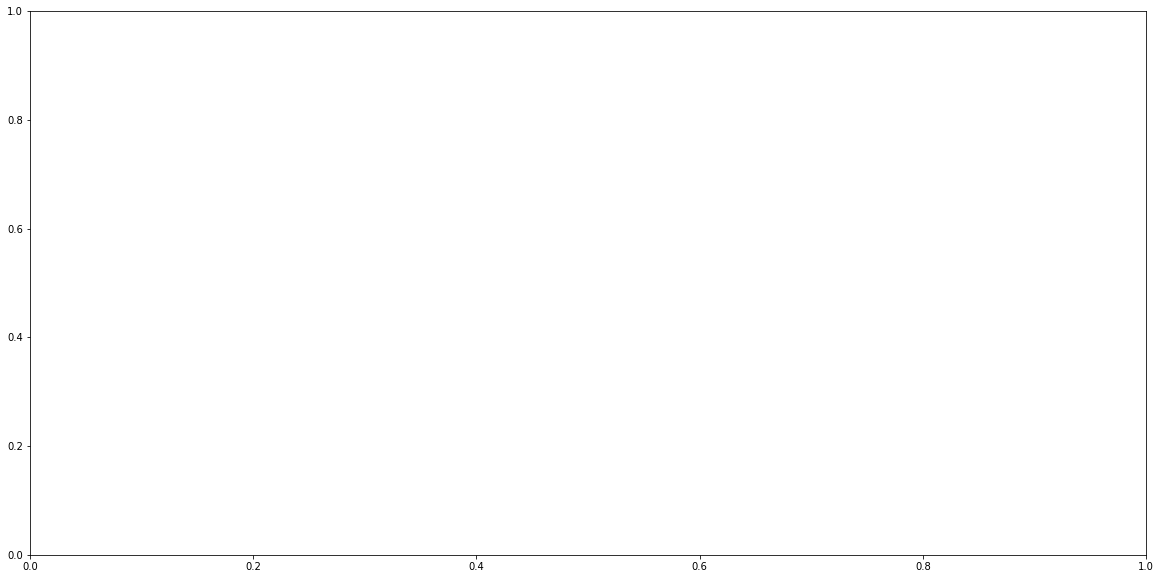

In [477]:
from random import sample

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)


from collections import Counter
import plotly.graph_objects as go
import plotly.io as pio


# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

# outlier_years = list(years_topic_wise[-1])
clustered_years = [value for key, value in years_topic_wise.items() if key!=1]


plot_top=Counter()
top_terms = top_n_words

num = []
for key, a in top_terms.items():
  k = []
  for i in a:
    for j in a:
        if  i!=j and i in j:
            k.append(i)

  r = list(filter(lambda i: i not in k, a))
  top_terms[key]  = r


for  b in clustered_years:
        k=b
        k=b.sort()


topic_years = ['.'.join(str(e) for e in years_topic_wise[item]) for item in clustered.labels]
topic_years_outliers = ['.'.join(str(e) for e in years_topic_wise[item]) for item in outliers.labels]



top_terms_docs = ['.'.join(str(e) for e in top_terms[item]) for item in clustered.labels]
top_terms_docs_outliers = ['.'.join(str(e) for e in top_terms[item]) for item in outliers.labels]


df1 = pd.DataFrame({'doc_terms_outliers':top_terms_docs_outliers,'doc_years_outliers':topic_years_outliers})


df2 = pd.DataFrame({'doc_terms':top_terms_docs, 'doc_years':topic_years})



pio.renderers.default = "browser"
import plotly.express as px

color_discrete_sequence=["#CD6155", '#9a4979', '#62b9cc', '#873600', '#117A65', '#de881f', '#CB4335',
                        '#c43f93','#3dccd1','#e07141','#e041a0','#0f00cd','#ffa700','#d62d20','#008844','#72bd68','#ba434f','#48c2ba','#945edb','#e206cb','#cfd63c','#ca3bf9','#bfc403','#ba0e37','#9aa655','#8e471b','#473100',
                         '#fda025','#21618C', '#6C3483', '#91ca1e','#EB984E', '#239B56','#1A5276']

clustered['Publication Years'] = topic_years
clustered['Topic Words'] = top_terms_docs
clustered['Cluster Number'] = clustered.labels
fig = px.scatter(clustered, x='x', y='y', hover_name='titles',color='Topic Words',
                 # labels={"Topic Words" : "Topics"},
                    hover_data=['Publication Years', 'Cluster Number'], color_discrete_sequence=color_discrete_sequence)


fig.add_trace(go.Scatter(x=outliers.x, y=outliers.y,customdata=df1, mode='markers', hovertext=outliers.titles,
                         name='outliers',
                                     marker=dict(
                                         color='#BDBDBD',
                                     ),
                                     hoverlabel=dict(
                                         bgcolor="#ffffff",
                                         font_size=12,
                                         font_color="#141414",
                                         font_family="Calibri",
                                         bordercolor="#BDBDBD",
                                     ),
                                    hovertemplate='<b>%{hovertext}<br></b><br><br>Topic= %{customdata[0]}</br>Years = %{customdata[1]}<br>'
                                     ))
fig.update_layout(
            margin=dict(l=5, r=5, b=30),
            xaxis_title='',
            yaxis_title='',
            xaxis=dict(
                showline=True,
                showgrid=True,
                linecolor='#666666',
                tickfont=dict(
                    family='poppins',
                    color='#666666'
                )
            ),
            yaxis=dict(  # attribures for y axis
                showline=True,
                showgrid=True,
                linecolor='#666666',
                tickfont=dict(
                    family='poppins',
                    color='#666666'
                )
            ),
            hoverlabel=dict(
                bgcolor="#ffffff",
                font_size=12,
                font_color="#141414",
                font_family="Calibri",
                bordercolor="#204ab3",
            ),
            plot_bgcolor='white',
        )


In [478]:
# dis = top_n_words
# for k, v in dis.items():
#     i = ', '.join(v)
#     dis[k]=i
# dis

In [256]:
# yr =years_topic_wise
# for k, v in yr.items():
#     i = ', '.join(v)
#     yr[k]=i
# yr

['simulation', 'stress', 'blood vessels', 'mitral valve']


In [258]:
# result = {}
# for k, v in dis.items():
#     l = v + ' & ' + yr[k]
#     result[k] = l
# result

['simulation', 'stress', 'blood vessels', 'mitral valve']

In [ ]:
# c = [len(v) for v in top_terms.values()]
# print(min(c))
# for k, v in top_terms.items():
#     top_terms[k] = sample(v[::len(v) // min(c)], min(c))

